<a href="https://colab.research.google.com/github/Clayrisee/Kikuma/blob/main/Model_Kikuma_Improvement_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [8]:
# Libraries for manage the file in os and in the gdrive.
from google.colab import drive
import os

# For read the image
import glob as gb

# Libraries for do visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for do computational things
import numpy as np
import pandas as pd


import datetime

# For evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# Libraries for Deep learning tasks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

# Prepare the Dataset

## Mount the Google Drive

In [9]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Prepare the dataset path

In [10]:
BASE_DIR = '/content/gdrive/MyDrive/dataset/dataset_v3' 
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

## Inspect the Dataset '3'

In [11]:
def img_count_in_folder(FOLDER_PATH):  
  print('-'*70)
  for folder in os.listdir(FOLDER_PATH):
    files=gb.glob(pathname=str(FOLDER_PATH + '/' + folder + '/*.jpg'))
    print(f'{len(files):4} gambar yang ditemukan di dalam folder {folder}')
  print('-'*70)

In [12]:
print(''*15+'Training Folder'+''*15)
img_count_in_folder(TRAIN_DIR)

Training Folder
----------------------------------------------------------------------
 884 gambar yang ditemukan di dalam folder Chickenpox
 868 gambar yang ditemukan di dalam folder Scabies
 800 gambar yang ditemukan di dalam folder Melanoma
----------------------------------------------------------------------


In [13]:
print(''*15+'Validation Folder'+''*15)
print(VAL_DIR)
img_count_in_folder(VAL_DIR)

Validation Folder
/content/gdrive/MyDrive/dataset/dataset_v3/val
----------------------------------------------------------------------
 100 gambar yang ditemukan di dalam folder Scabies
 131 gambar yang ditemukan di dalam folder Chickenpox
 100 gambar yang ditemukan di dalam folder Melanoma
----------------------------------------------------------------------


In [14]:
print(''*15+'TEST Folder'+''*15)
print(TEST_DIR)
img_count_in_folder(TEST_DIR)

TEST Folder
/content/gdrive/MyDrive/dataset/dataset_v3/test
----------------------------------------------------------------------
 100 gambar yang ditemukan di dalam folder Melanoma
 100 gambar yang ditemukan di dalam folder Scabies
 138 gambar yang ditemukan di dalam folder Chickenpox
----------------------------------------------------------------------


## Visualize some images in the dataset '-')b

In [15]:
def show_images(img_files):
  plt.figure()
  fig = plt.figure(figsize=(10, 10))
  fig.patch.set_facecolor('xkcd:gray')

  for i in range(len(img_files)):
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        img=mpimg.imread(img_files[i])
        plt.imshow(img)
        plt.tight_layout()
        plt.axis('off')
        plt.title(img_files[i].split("/")[7]) 
    
  plt.show()


def list_files(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            if name.endswith(".jpg"):
              arr.append(os.path.join(root, name))
              break
    return arr

['/content/gdrive/MyDrive/dataset/dataset_v3/train/Chickenpox/chickenpox31.jpg', '/content/gdrive/MyDrive/dataset/dataset_v3/train/Scabies/scabies8.jpg', '/content/gdrive/MyDrive/dataset/dataset_v3/train/Melanoma/melanocytic-nevi-61.jpg']


<Figure size 432x288 with 0 Axes>

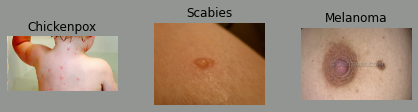

In [16]:
image_list = list_files(TRAIN_DIR)
print(image_list)
show_images(image_list)

# Do Image Augmentation

In [17]:
# Datagen for validation set dan training set
datagen = ImageDataGenerator(
                             rescale = 1./255,
                             rotation_range = 45,
                             zoom_range = 0.1,
                             width_shift_range=0.15, 
                             shear_range= 0.1,
                             height_shift_range=0.15,
                             horizontal_flip=True,
                             vertical_flip= True,
                             fill_mode='nearest',
                             )

# ImageDataGenerator for test set
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Let's try with 224, 224
IMG_SIZE = (224, 224)

# Create train dataset
train_set = datagen.flow_from_directory(TRAIN_DIR, 
                                        class_mode='categorical', 
                                        batch_size= 64,
                                        target_size=IMG_SIZE,
                                        seed=42)

Found 2577 images belonging to 3 classes.


In [19]:
os.listdir(TRAIN_DIR)

['Chickenpox', 'Scabies', 'Melanoma']

In [20]:
os.listdir(VAL_DIR)

['Scabies', 'Chickenpox', 'Melanoma']

In [21]:
val_set= val_test_datagen.flow_from_directory(VAL_DIR, 
                                       class_mode='categorical',
                                       batch_size= 64,
                                       target_size=IMG_SIZE
                                       )

Found 333 images belonging to 3 classes.


In [22]:
test_set = val_test_datagen.flow_from_directory(TEST_DIR, 
                                       class_mode='categorical',
                                       batch_size= 64,
                                       target_size=IMG_SIZE
                                       )

Found 340 images belonging to 3 classes.


In [23]:
val_set.class_indices

{'Chickenpox': 0, 'Melanoma': 1, 'Scabies': 2}

In [24]:
test_set.class_indices

{'Chickenpox': 0, 'Melanoma': 1, 'Scabies': 2}

In [25]:
train_set.class_indices

{'Chickenpox': 0, 'Melanoma': 1, 'Scabies': 2}

# Inspect the image after Augmentation process

In [26]:
# Create variabel X_train and y_train
X_train, y_train = train_set.next()

# Create variabel X_test and y_test
X_test, y_test = test_set.next()

# Create variabel X_val and y_val
X_val, y_val = val_set.next()

In [27]:
class_dict = {v : k for k, v in train_set.class_indices.items()}

def plot_augmented_imgs(X, y):
  labels=[]
  y_label = np.argmax(y, axis=1)
  
  for label in y_label:
    labels.append(class_dict[label])

  for idx in range(0,10):
      plt.figure(figsize=(5, 5))
      plt.imshow(X_train[idx])
      plt.title(labels[idx])

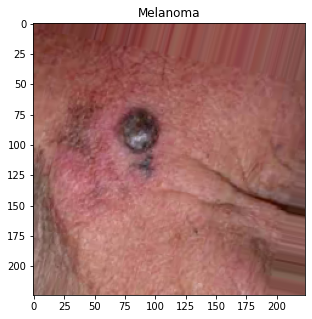

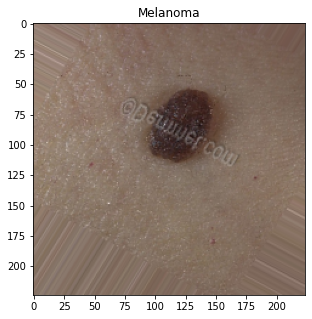

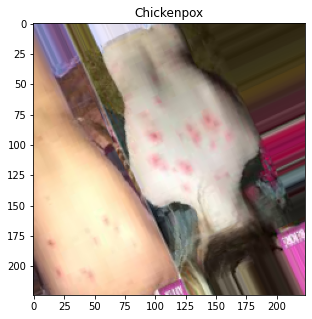

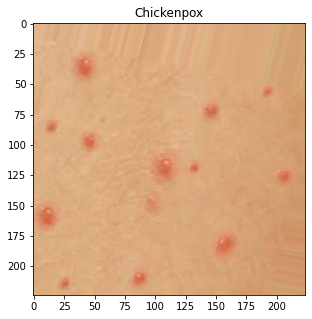

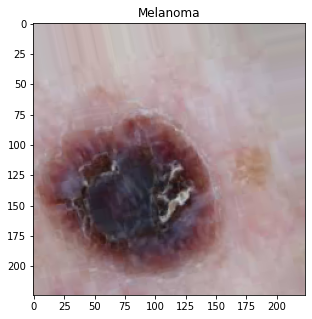

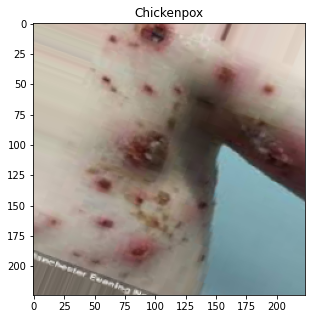

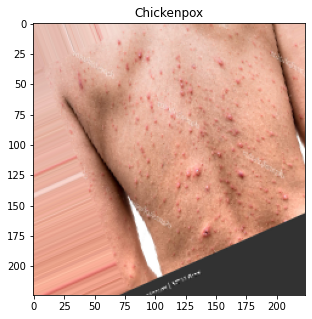

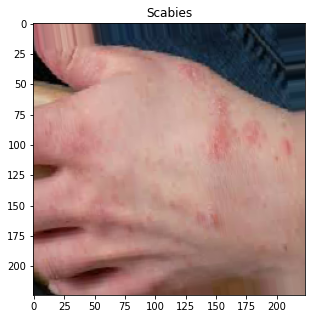

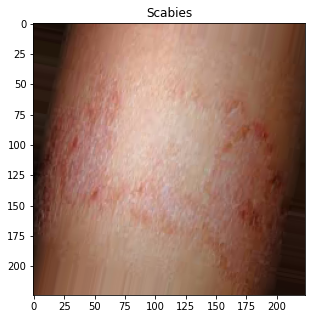

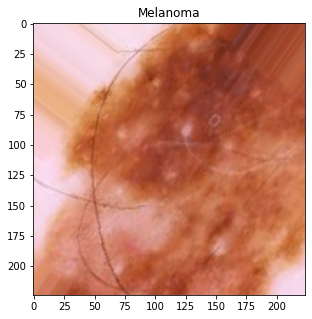

In [28]:
plot_augmented_imgs(X_train, y_train)

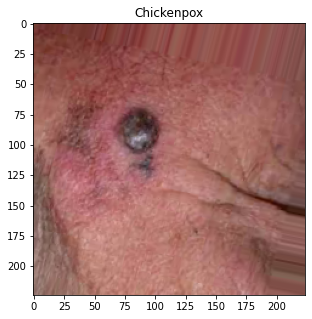

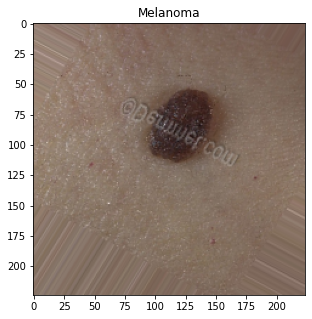

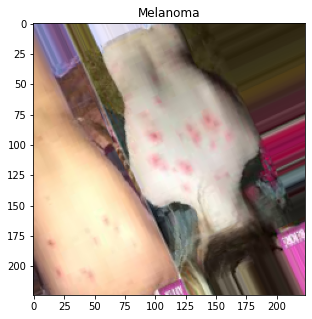

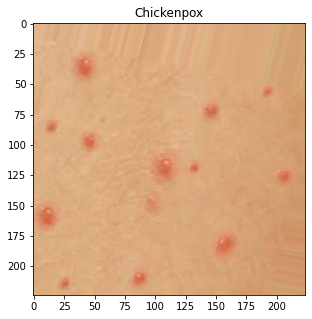

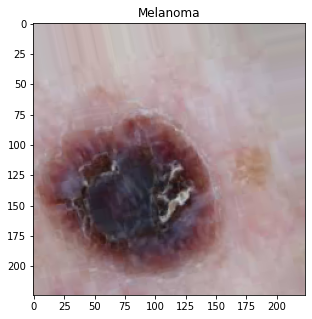

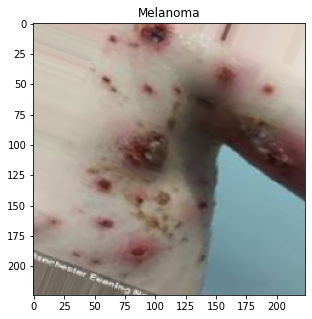

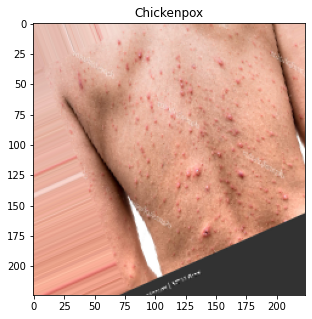

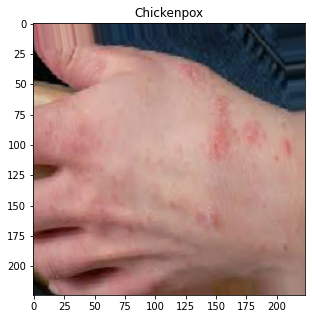

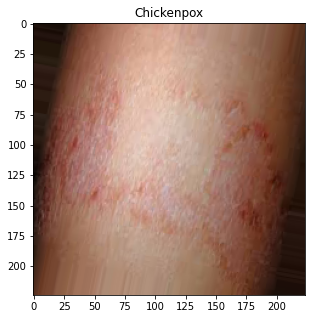

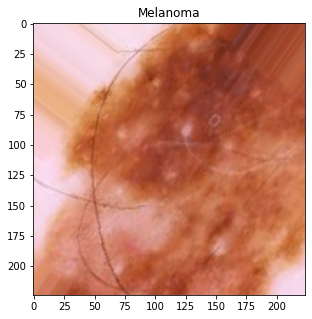

In [29]:
plot_augmented_imgs(X_val, y_val)

# Build the Model

## Prepare Callbacks for the Training Progress

In [51]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=1e-8)
checkpoint_cb = ModelCheckpoint("current_best_model.h5", saved_best_only=True)
early_stop_cb = EarlyStopping(patience=10,monitor='val_loss', restore_best_weights= True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, 
                                                   histogram_freq=1)
# Clear any logs from previous runs
!rm -rf ./logs/ 

callbacks =[reduce_lr, checkpoint_cb, early_stop_cb, tensorboard_callback]


## Prepare the relevant function to evaluate and training progress

In [40]:
def evaluate_model(model, X, y):
  print('Loss of the model is - ', model.evaluate(X, y)[0])
  print('Accuracy of the model is - ', model.evaluate(X, y)[1]*100, '%')
  predict = model.predict(X)
  # print(predict)
  predict = np.argmax(predict, axis=1)
  predict = predict.reshape(1, -1)[0]
  y_label = np.argmax(y, axis=1)
  print(classification_report(y_label, predict, target_names =['Chickenpox', 'Melanoma', 'Scabies']))

  conf_matrix = confusion_matrix(y_label, predict)
  # print(conf_matrix)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in ('Chickenpox', 'Melanoma', 'Scabies')],
                  columns = [i for i in ('Chickenpox', 'Melanoma', 'Scabies')])
  plt.figure(figsize = (3, 3))
  sns.heatmap(df_cm, annot=True)

plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'orange')
  val_acc_plot, = plt.plot(epochs, val_acc, 'blue')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'orange')
  val_loss_plot, = plt.plot(epochs, val_loss, 'blue')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_hist(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

## Train the Model

In [52]:
# Define xception based Model using 224, 224 input image and pooling max
xception_based_model = Xception(weights='imagenet', input_shape=(224, 224 ,3), include_top=False, pooling='max')
x = xception_based_model.output

# Define the MLP for classification
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
predictions = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=xception_based_model.input, outputs = predictions)

# freeze all layer in xception_based_model for training process,
for layer in xception_based_model.layers:
  layer.trainable = False
optimizer=Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [53]:
# Trains for 10 epochs
hist = model.fit(train_set, epochs=10, validation_data = val_set, verbose = 1, callbacks=callbacks,
          )

Epoch 1/10
41/41 [==============================] - 43s 973ms/step - loss: 2.9899 - accuracy: 0.6474 - val_loss: 3.0851 - val_accuracy: 0.7868
Epoch 2/10
41/41 [==============================] - 38s 919ms/step - loss: 2.7298 - accuracy: 0.7198 - val_loss: 2.5417 - val_accuracy: 0.8288
Epoch 3/10
41/41 [==============================] - 38s 915ms/step - loss: 2.5158 - accuracy: 0.7524 - val_loss: 2.5941 - val_accuracy: 0.8078
Epoch 4/10
41/41 [==============================] - 38s 919ms/step - loss: 2.3622 - accuracy: 0.7757 - val_loss: 2.2767 - val_accuracy: 0.8108
Epoch 5/10
41/41 [==============================] - 38s 914ms/step - loss: 2.2277 - accuracy: 0.7792 - val_loss: 2.2101 - val_accuracy: 0.8228
Epoch 6/10
41/41 [==============================] - 38s 919ms/step - loss: 2.1177 - accuracy: 0.7775 - val_loss: 1.9073 - val_accuracy: 0.8649
Epoch 7/10
41/41 [==============================] - 38s 916ms/step - loss: 1.9574 - accuracy: 0.7898 - val_loss: 1.9080 - val_accuracy: 0.8468

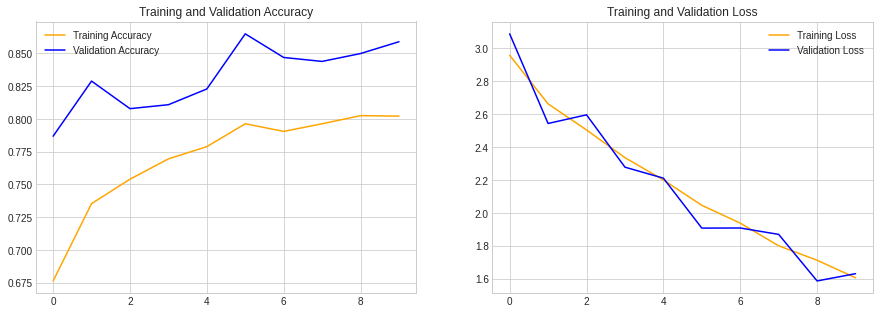

In [54]:
plot_hist(hist)

2/2 [==============================] - 1s 134ms/step - loss: 1.6512 - accuracy: 0.7812
Loss of the model is -  1.651243805885315
2/2 [==============================] - 0s 128ms/step - loss: 1.6512 - accuracy: 0.7812
Accuracy of the model is -  78.125 %
              precision    recall  f1-score   support

  Chickenpox       0.74      0.80      0.77        25
    Melanoma       0.79      0.83      0.81        18
     Scabies       0.83      0.71      0.77        21

    accuracy                           0.78        64
   macro avg       0.79      0.78      0.78        64
weighted avg       0.78      0.78      0.78        64



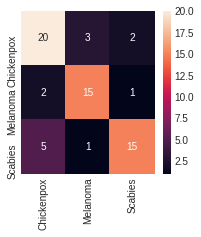

In [55]:
evaluate_model(model, X_test, y_test)

## Unfreeze the last 10 layer of the xception model and includes them in training progress.

In [56]:
optimizer=Adam()

# unfreeze last 10 layers and include them in training process
for layer in xception_based_model.layers[-10:]:
  layer.trainable=True
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [57]:
# Retrain the model with 100 epochs
hist = model.fit(train_set, epochs=100, validation_data = val_set, verbose = 1, callbacks=callbacks,
          )

Epoch 1/100
41/41 [==============================] - 43s 984ms/step - loss: 1.5001 - accuracy: 0.7622 - val_loss: 1.3814 - val_accuracy: 0.8108
Epoch 2/100
41/41 [==============================] - 39s 937ms/step - loss: 1.1043 - accuracy: 0.8426 - val_loss: 1.0597 - val_accuracy: 0.8288
Epoch 3/100
41/41 [==============================] - 38s 933ms/step - loss: 0.9199 - accuracy: 0.8690 - val_loss: 1.0964 - val_accuracy: 0.8649
Epoch 4/100
41/41 [==============================] - 39s 935ms/step - loss: 0.8042 - accuracy: 0.8828 - val_loss: 0.6786 - val_accuracy: 0.9099
Epoch 5/100
41/41 [==============================] - 38s 934ms/step - loss: 0.6612 - accuracy: 0.8871 - val_loss: 0.7942 - val_accuracy: 0.8799
Epoch 6/100
41/41 [==============================] - 39s 936ms/step - loss: 0.5713 - accuracy: 0.9052 - val_loss: 0.6181 - val_accuracy: 0.8919
Epoch 7/100
41/41 [==============================] - 38s 932ms/step - loss: 0.5035 - accuracy: 0.8951 - val_loss: 0.4893 - val_accuracy:

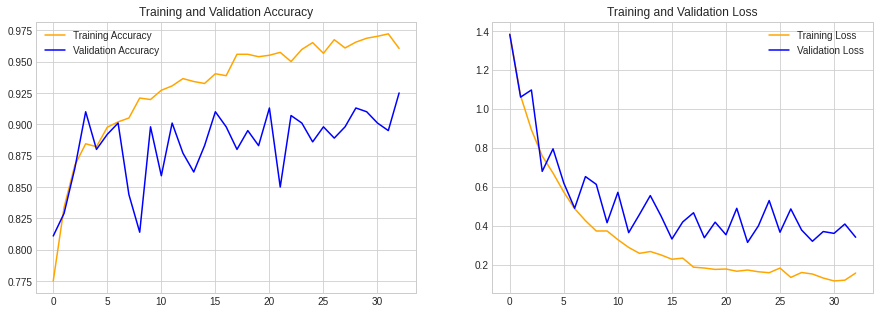

In [61]:
plot_hist(hist)

2/2 [==============================] - 1s 145ms/step - loss: 0.4402 - accuracy: 0.8594
Loss of the model is -  0.4401842951774597
2/2 [==============================] - 0s 134ms/step - loss: 0.4402 - accuracy: 0.8594
Accuracy of the model is -  85.9375 %
              precision    recall  f1-score   support

  Chickenpox       0.84      0.84      0.84        25
    Melanoma       1.00      0.89      0.94        18
     Scabies       0.78      0.86      0.82        21

    accuracy                           0.86        64
   macro avg       0.87      0.86      0.87        64
weighted avg       0.87      0.86      0.86        64



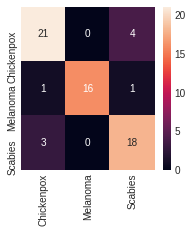

In [59]:
evaluate_model(model, X_test, y_test)

For this experiment we can conclude that my model is overfitting to melanoma disease. It's a bad model, so we should do a earlystop so the training progress will stop if the val loss trend is getting bigger and bigger.

## Check the best model

2/2 [==============================] - 1s 131ms/step - loss: 0.5527 - accuracy: 0.9375
Loss of the model is -  0.5527180433273315
2/2 [==============================] - 0s 134ms/step - loss: 0.5527 - accuracy: 0.9375
Accuracy of the model is -  93.75 %
              precision    recall  f1-score   support

  Chickenpox       1.00      0.92      0.96        25
    Melanoma       1.00      0.89      0.94        18
     Scabies       0.84      1.00      0.91        21

    accuracy                           0.94        64
   macro avg       0.95      0.94      0.94        64
weighted avg       0.95      0.94      0.94        64



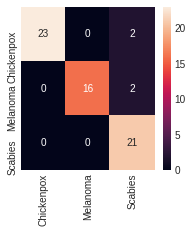

In [60]:
from tensorflow.keras.models import load_model
best_model = load_model('/content/current_best_model.h5')
evaluate_model(best_model,  X_test, y_test)

## Try to adjust learning rate and see if we can got the better result than that model.

### First Try, change the learning rate into 0.000005 :/

In [62]:
# Make a backup if i messed up in the future.

os.mkdir('/content/gdrive/MyDrive/model/current_best_model/paling baru/v3/')
best_model.save('/content/gdrive/MyDrive/model/current_best_model/paling baru/v3/best_model.h5')
best_model.save('/content/gdrive/MyDrive/model/current_best_model/paling baru/v3/')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model/current_best_model/paling baru/v3/assets


In [67]:
# Change the learning rate and see the difference
optimizer=Adam(0.000005)

# unfreeze last 15 layers and include them in training process
for layer in best_model.layers[-15:]:
  layer.trainable= True
best_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(best_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [68]:
# Retrain the model with 100 epochs
hist = best_model.fit(train_set, epochs=100, validation_data = val_set, verbose = 1, callbacks=callbacks,
          )

Epoch 1/100
41/41 [==============================] - 43s 989ms/step - loss: 0.1296 - accuracy: 0.9729 - val_loss: 0.3249 - val_accuracy: 0.9219
Epoch 2/100
41/41 [==============================] - 40s 965ms/step - loss: 0.1133 - accuracy: 0.9805 - val_loss: 0.3206 - val_accuracy: 0.9249
Epoch 3/100
41/41 [==============================] - 39s 956ms/step - loss: 0.1349 - accuracy: 0.9691 - val_loss: 0.3194 - val_accuracy: 0.9279
Epoch 4/100
41/41 [==============================] - 39s 948ms/step - loss: 0.1190 - accuracy: 0.9724 - val_loss: 0.3182 - val_accuracy: 0.9279
Epoch 5/100
41/41 [==============================] - 39s 948ms/step - loss: 0.1158 - accuracy: 0.9797 - val_loss: 0.3169 - val_accuracy: 0.9279
Epoch 6/100
41/41 [==============================] - 40s 972ms/step - loss: 0.1199 - accuracy: 0.9710 - val_loss: 0.3170 - val_accuracy: 0.9279
Epoch 7/100
41/41 [==============================] - 39s 969ms/step - loss: 0.1239 - accuracy: 0.9707 - val_loss: 0.3157 - val_accuracy:

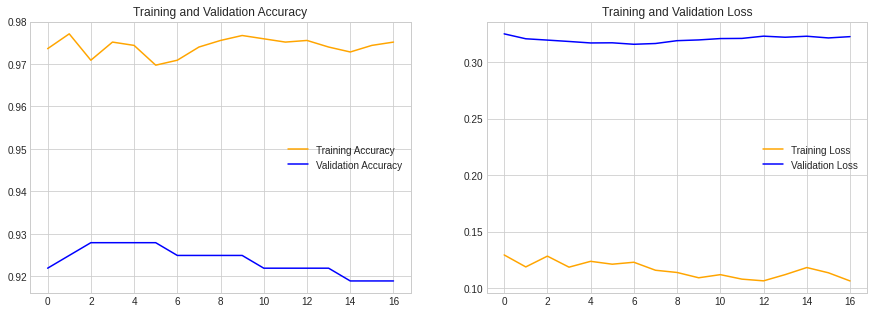

In [69]:
plot_hist(hist)

2/2 [==============================] - 1s 142ms/step - loss: 0.4394 - accuracy: 0.9375
Loss of the model is -  0.4394384026527405
2/2 [==============================] - 0s 124ms/step - loss: 0.4394 - accuracy: 0.9375
Accuracy of the model is -  93.75 %
              precision    recall  f1-score   support

  Chickenpox       1.00      0.92      0.96        25
    Melanoma       1.00      0.89      0.94        18
     Scabies       0.84      1.00      0.91        21

    accuracy                           0.94        64
   macro avg       0.95      0.94      0.94        64
weighted avg       0.95      0.94      0.94        64



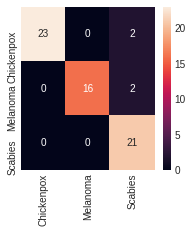

In [70]:
evaluate_model(best_model, X_test, y_test)

### Second try, after that. I tried to change learning rate into 3e-7

In [71]:
# Change the learning rate and see the difference
optimizer=Adam(3e-7)

# unfreeze last 15 layers and include them in training process
for layer in best_model.layers[-15:]:
  layer.trainable= True
best_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(best_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [72]:
# Retrain the model with 100 epochs
hist = best_model.fit(train_set, epochs=100, validation_data = val_set, verbose = 1, callbacks=callbacks,
          )

Epoch 1/100
41/41 [==============================] - 46s 1s/step - loss: 0.1137 - accuracy: 0.9742 - val_loss: 0.3162 - val_accuracy: 0.9249
Epoch 2/100
41/41 [==============================] - 41s 987ms/step - loss: 0.1143 - accuracy: 0.9714 - val_loss: 0.3160 - val_accuracy: 0.9249
Epoch 3/100
41/41 [==============================] - 41s 987ms/step - loss: 0.1069 - accuracy: 0.9791 - val_loss: 0.3158 - val_accuracy: 0.9249
Epoch 4/100
41/41 [==============================] - 40s 962ms/step - loss: 0.1062 - accuracy: 0.9783 - val_loss: 0.3154 - val_accuracy: 0.9249
Epoch 5/100
41/41 [==============================] - 39s 958ms/step - loss: 0.1079 - accuracy: 0.9808 - val_loss: 0.3161 - val_accuracy: 0.9249
Epoch 6/100
41/41 [==============================] - 40s 959ms/step - loss: 0.1095 - accuracy: 0.9775 - val_loss: 0.3162 - val_accuracy: 0.9249
Epoch 7/100
41/41 [==============================] - 40s 956ms/step - loss: 0.1064 - accuracy: 0.9763 - val_loss: 0.3158 - val_accuracy: 0.

2/2 [==============================] - 1s 129ms/step - loss: 0.4365 - accuracy: 0.9375
Loss of the model is -  0.43650883436203003
2/2 [==============================] - 0s 129ms/step - loss: 0.4365 - accuracy: 0.9375
Accuracy of the model is -  93.75 %
              precision    recall  f1-score   support

  Chickenpox       1.00      0.92      0.96        25
    Melanoma       1.00      0.89      0.94        18
     Scabies       0.84      1.00      0.91        21

    accuracy                           0.94        64
   macro avg       0.95      0.94      0.94        64
weighted avg       0.95      0.94      0.94        64



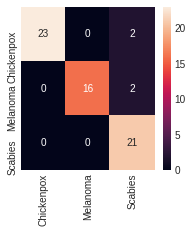

In [73]:
evaluate_model(best_model, X_test, y_test)

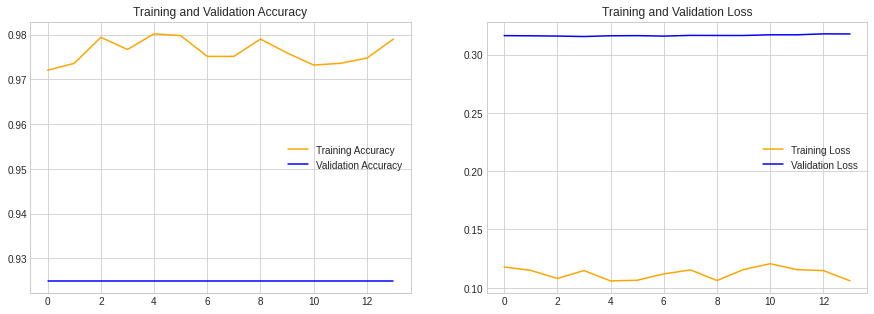

In [74]:
plot_hist(hist)

From two experiment above, i can conclude that even we change the learning rate into small learning rate, the model still overfit. The way to solve this problem to add more data into scabies class. in addition, we can also add more variance in our dataset, like the skin colour, the condition that photo being taken, etc.


# Save the final Model into Google Drive Folder.

In [76]:
best_model.save('/content/gdrive/MyDrive/model/Xception_best_model/best_model.h5')
os.mkdir('/content/gdrive/MyDrive/model/current_best_model/Xception_best_model/saved_model_format')
best_model.save('/content/gdrive/MyDrive/model/current_best_model/Xception_best_model/saved_model_format')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model/current_best_model/Xception_best_model/saved_model_format/assets


Thanks! That's all from me!